# Using dask to scale the analysis of data on the cloud

## Explore data with xarray

In [1]:
import xarray as xr

In [2]:
# Let's open a dataset that is sitting on the cloud
store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/cmip6-feedstock/CMIP6.CMIP.CCCma.CanESM5.historical.r1i1p1f1.Omon.zos.gn.v20190429.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})
ds

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, time: 1980, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    zos                 (time, j, i) float32 dask.array<chunksize=(360, 291, 360), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    title:                       CanESM5 output prepared for CMIP6
    tracking_id:                 hdl:21.14100/99be0cf0-54b1-405b-b46c-e69c274...
    variable_id:                 zos
    variant_label:               r1i1p1f1
    version:                     v20190429

In [3]:
# We look at one variable 
ds['zos']

<xarray.DataArray 'zos' (time: 1980, j: 291, i: 360)>
dask.array<open_dataset-acf05d6877df471e3e237f134268820fzos, shape=(1980, 291, 360), dtype=float32, chunksize=(360, 291, 360), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 283 284 285 286 287 288 289 290
    latitude   (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        zos is obtained directly from the free-surface model., CM...
    history:        sub_timeseries
    long_name:      Sea Surface Height Above Geoid
    original_name:  sossheig
    standard_name:  sea_surface_height_above_geoid
    units:          m

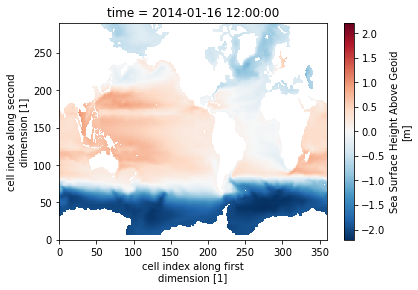

In [4]:
# We plot a map at one date
ds['zos'].sel(time="2014-01-16").plot()

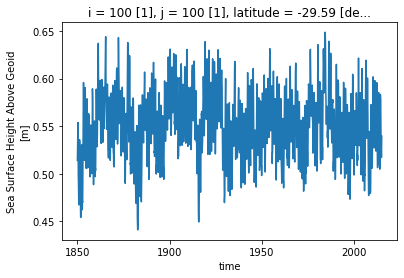

In [5]:
# A time serie at one location
ds['zos'].isel(i=100,j=100).plot()

An important aspect of xarray is that it allows lazily-evaluated operations.

That means that computation is not done right away but planned for when we actually need the result, to plot or print for instance.

In [6]:
%%time
#That is why this is quasi instantaneous
ds['zos'].mean(dim='time')

CPU times: user 2.59 ms, sys: 0 ns, total: 2.59 ms
Wall time: 2.53 ms


<xarray.DataArray 'zos' (j: 291, i: 360)>
dask.array<mean_agg-aggregate, shape=(291, 360), dtype=float32, chunksize=(291, 360), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 283 284 285 286 287 288 289 290
    latitude   (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>

CPU times: user 2.55 s, sys: 1.42 s, total: 3.97 s
Wall time: 1.99 s


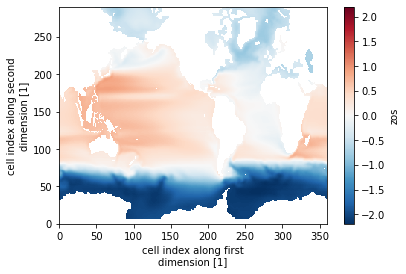

In [7]:
%%time
# and this takes some time
ds['zos'].mean(dim='time').plot()

CPU times: user 3.44 s, sys: 1.68 s, total: 5.12 s
Wall time: 2.16 s


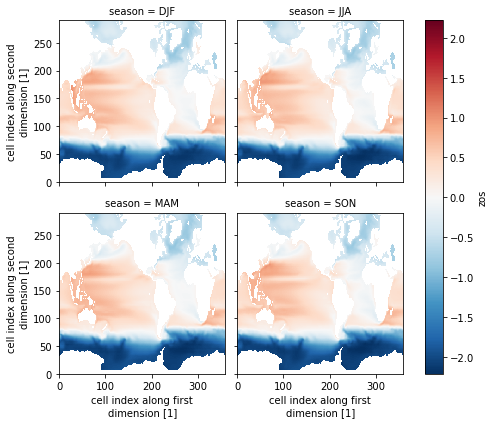

In [8]:
%%time
# A more complex operation : seasonal mean
ssh_seasonal = ds['zos'].groupby("time.season").mean()
ssh_seasonal.plot(col="season", col_wrap=2)

## Let's use xarray with dask

In [9]:
import dask

Click on the dask symbol on the left, then on +NEW button

Wait for the cluster to launch, then drag and drop the blue box in a cell below, and execute it

In [11]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40977")
client

<Client: 'tcp://127.0.0.1:40977' processes=4 threads=8, memory=29.39 GiB>

Select some dashboard metrics to follow : Progress, Task Stream, CPU and Cluster Memory, and rearrange the lab windows

Let's open a new dataset

In [12]:
#This is a satellite product of the sea surface height available from anywhere thanks to the pangeo catalog
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["sea_surface_height"].to_dask()
ds

<xarray.Dataset>
Dimensions:    (time: 8901, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(5, 720, 2), meta=np.ndarray>
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    lon_bnds   (longitude, nv) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [13]:
# One variable size in Gb
ds.sla.nbytes/1e9

73.8284544

In [14]:
# We only have 15Gb available but we can still handle this variable
xymean = ds.sla.mean(dim=('latitude', 'longitude'))

In [15]:
%%time
# Nothing is happenning while we do not load the computation
xymean.load()

CPU times: user 2.39 s, sys: 597 ms, total: 2.99 s
Wall time: 2min 1s


<xarray.DataArray 'sla' (time: 8901)>
array([0.00207974, 0.00185178, 0.00166995, ..., 0.06688241, 0.06690208,
       0.0668637 ])
Coordinates:
    crs      int32 -2147483647
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15

In [16]:
%%time
#when we run it a second time it will be even faster
xymean.load()

CPU times: user 81 µs, sys: 35 µs, total: 116 µs
Wall time: 123 µs


<xarray.DataArray 'sla' (time: 8901)>
array([0.00207974, 0.00185178, 0.00166995, ..., 0.06688241, 0.06690208,
       0.0668637 ])
Coordinates:
    crs      int32 -2147483647
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15

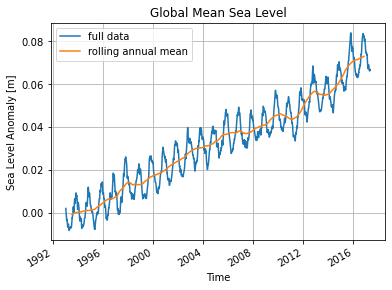

In [17]:
# That is why this plot is so fast

import matplotlib.pyplot as plt
xymean.plot(label='full data')
xymean.rolling(time=365, center=True).mean().plot(label='rolling annual mean')
plt.ylabel('Sea Level Anomaly [m]')
plt.title('Global Mean Sea Level')
plt.legend()
plt.grid()

In [18]:
#Let's have a look at the chunks
ds.sla

<xarray.DataArray 'sla' (time: 8901, latitude: 720, longitude: 1440)>
dask.array<open_dataset-ab02c27f0096e26df3010a5fc101ad3bsla, shape=(8901, 720, 1440), dtype=float64, chunksize=(5, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Attributes:
    comment:        The sea level anomaly is the sea surface height above mea...
    grid_mapping:   crs
    long_name:      Sea level anomaly
    standard_name:  sea_surface_height_above_sea_level
    units:          m

In [19]:
%%time
tmean=ds.sla.mean(dim=('time'))
tmean.load()

CPU times: user 582 ms, sys: 48.5 ms, total: 631 ms
Wall time: 1min 55s


<xarray.DataArray 'sla' (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9